When benchmarking you **MUST**

1. close all applications
2. close docker
3. close all but this Web windows
4. all pen editors other than jupyter-lab (this notebook)


In [38]:
import os
from cloudmesh.common.Shell import Shell
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
from tqdm.notebook import tqdm
from cloudmesh.common.util import readfile
from cloudmesh.common.util import writefile
from cloudmesh.common.StopWatch import StopWatch 
from cloudmesh.common.systeminfo import systeminfo
import ipywidgets as widgets

sns.set_theme(style="whitegrid")

In [39]:
info = systeminfo()
user = info["user"]
node = info["uname.node"]
processors = 4

In [57]:
p = widgets.IntSlider(
    value=processors,
    min=2,
    max=64,
    step=1,
    description='Processors:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
u = widgets.Text(value=user, placeholder='The user name', description='User:', disabled=False)
n = widgets.Text(value=node, placeholder='The computer name', description='Computer:', disabled=False)

display(p)
display(u)
display(n)

IntSlider(value=4, continuous_update=False, description='Processors:', max=64, min=2)

Text(value='gregor', description='User:', placeholder='The user name')

Text(value='alienware', description='Computer:', placeholder='The computer name')

In [58]:
processors = p.value
user = u.value
node = n.value
print (processors, user, node)

4 gregor alienware


In [59]:

experiments = 10
maximum = 1024 * 100000
intervals = 10

In [60]:
label = f"{user}-{node}-{processors}"
output = f"benchmark/{user}"

delta = int(maximum / intervals)

totals = [64] + list(range(0,maximum, delta))[1:]
points = [int(t/processors) for t in totals]
print (totals)
print(points)

[64, 10240000, 20480000, 30720000, 40960000, 51200000, 61440000, 71680000, 81920000, 92160000]
[16, 2560000, 5120000, 7680000, 10240000, 12800000, 15360000, 17920000, 20480000, 23040000]


In [61]:
os.makedirs(output, exist_ok=True)

In [62]:
systeminfo = StopWatch.systeminfo()
writefile(f"{output}/{label}-sysinfo.log", systeminfo)
print (systeminfo)

+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | hirsute                                                          |
| DISTRIB_DESCRIPTION | "Ubuntu 21.04"                                                   |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 21.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           |

In [63]:
df = pd.DataFrame(
{"Size": points}
)
df = df.set_index('Size')

In [64]:


experiment_progress = tqdm(range(0, experiments), desc ="Experiment")

experiment = -1
for experiment in experiment_progress:
    exoeriment = experiment + 1

    log = f"{output}/{label}-{experiment}-log.log"
    os.system(f"rm {log}")


    name = points[experiment]
    progress = tqdm(range(0, len(points)), 
                    desc =f"Benchmark {name}",
                    bar_format="{desc:<30} {total_fmt} {r_bar}")
    
    i = -1
    for state in progress:
        i = i + 1
        n = points[i]
        #if linux, os:
        command = f"mpiexec -n {processors} python count-click.py " + \
                  f"--n {n} --max_number 10 --find 8 --label {label} " + \
                  f"--user {user} --node={node} " + \
                  f"| tee -a {log}"
        #if windows: 
        #command = f"mpiexec -n {processors} python count-click.py " + \
        #          f"--n {n} --max_number 10 --find 8 --label {label} " + \
        #          f"--user {user} --node={node} " + \
        #          f">> {log}"
        
        os.system (command)

    content = readfile(log).splitlines()
    lines = Shell.cm_grep(content, "csv,Result:")
    # print(lines)
    values = []
    times = []

    for line in lines:
        msg = line.split(",")[7]
        t = line.split(",")[4]

        total, overall, trials, find, label = msg.split(" ")
        values.append(int(overall))
        times.append(float(t))
        # print (t, overall)


    #data = pd.DataFrame(values, times, columns=["Values", "Time"])

    #print (data.describe())
    #sns.lineplot(data=data, palette="tab10", linewidth=2.5)
    # df["Size"] = values
    df[f"Time_{experiment}"] = times
    # print(df)


Experiment:   0%|          | 0/10 [00:00<?, ?it/s]

Benchmark 16                   10 | 0/10 [00:00<?, ?it/s]

Benchmark 2560000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 5120000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 7680000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 10240000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 12800000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 15360000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 17920000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 20480000             10 | 0/10 [00:00<?, ?it/s]

Benchmark 23040000             10 | 0/10 [00:00<?, ?it/s]

In [65]:

df = df.rename_axis(columns="Time")
df
    

Time,Time_0,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9
Size,,,,,,,,,,
16,0.008,0.008,0.036,0.028,0.001,0.020,0.042,0.017,0.010,0.009
2560000,2.069,2.143,2.131,2.101,2.106,2.098,2.179,2.107,2.139,2.116
5120000,4.205,4.207,4.133,4.227,4.215,4.183,4.154,4.150,4.252,4.239
7680000,6.362,6.367,6.345,6.511,6.311,6.245,6.411,6.770,6.340,6.275
10240000,8.411,8.691,8.406,8.500,8.417,8.385,8.384,8.339,8.351,8.208
12800000,10.516,10.313,10.358,10.601,10.418,10.536,10.424,10.263,10.411,10.459
15360000,12.647,12.462,12.663,12.502,12.561,12.322,12.556,12.310,12.586,12.710
17920000,14.561,15.117,14.833,15.110,14.857,14.557,14.604,14.513,14.556,15.009
20480000,16.456,16.696,16.579,16.786,16.625,16.599,16.835,17.289,16.516,17.200


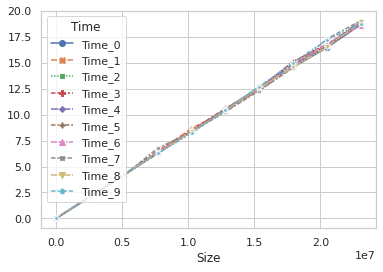

In [66]:
sns.lineplot(data=df, markers=True);

In [67]:
plt.savefig(f'{output}/{label}-line.png');
plt.savefig(f'{output}/{label}-line.pdf');

<Figure size 432x288 with 0 Axes>

In [68]:
dfs = df.stack().reset_index()
dfs = dfs.set_index('Size')
dfs = dfs.drop(columns=['Time'])
dfs = dfs.rename(columns={0:'Time'})
dfs

,Time
Size,
16,0.008
16,0.008
16,0.036
16,0.028
16,0.001
...,...
23040000,18.620
23040000,18.570
23040000,19.048


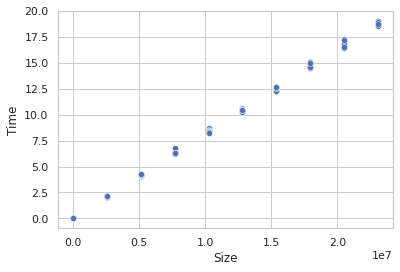

In [69]:
sns.scatterplot(data=dfs, x="Size", y="Time");
plt.savefig(f"{output}/{label}-scatter.pdf")
plt.savefig(f"{output}/{label}-scatter.png")

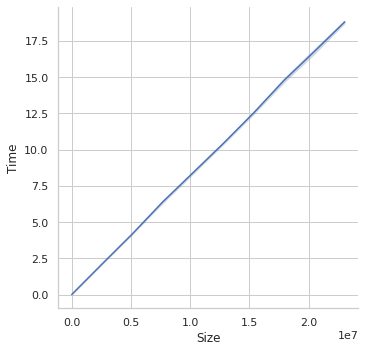

In [70]:
sns.relplot(x="Size", y="Time", kind="line", data=dfs);
plt.savefig(f"{output}/{label}-relplot.pdf")
plt.savefig(f"{output}/{label}-relplot.png")

In [71]:
df.to_pickle(f"{output}/{label}-df.pkl")